# Построение скоринговой модели бинарной классифкации по данным Home credit bank

План работы для анализа только данные application
1. Смотрим на признаки в целом (типы, размер и пропущенные значения)
2. Исследуем признаки по отдельности, заполняя пропуска и может быть создавая новые для количественных
3. Исследуем признаки на коллиниарность, отмечая те, которые сильно зависимые, потом может сплющим, если поможет
4. Кодируем категориальныех признаки (если надумаем не бустинг)
5. Убираем таргет, загоняем в модель LGBM, фитим
6. Проверяем на метриках
7. Смотрим на самые важные

## 1 ЗАГРУЗКА И ОБЩИЙ АНАЛИЗ

In [129]:
# загрузим базовые библиотеки для начала
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from lightgbm import LGBMClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, roc_auc_score
import shap

In [2]:
df_train = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_train.csv')
df_test = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_test.csv')

Смотрим на тренирочные данные

In [3]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


122 признака, 16 категориальных, таргет включена, бинарная классификация, может быть логистичекая регрессия тоже подойдет?

In [6]:
df_train.select_dtypes(include=[object]).apply(pd.Series.unique, axis = 0)

NAME_CONTRACT_TYPE                                [Cash loans, Revolving loans]
CODE_GENDER                                                         [M, F, XNA]
FLAG_OWN_CAR                                                             [N, Y]
FLAG_OWN_REALTY                                                          [Y, N]
NAME_TYPE_SUITE               [Unaccompanied, Family, Spouse, partner, Child...
NAME_INCOME_TYPE              [Working, State servant, Commercial associate,...
NAME_EDUCATION_TYPE           [Secondary / secondary special, Higher educati...
NAME_FAMILY_STATUS            [Single / not married, Married, Civil marriage...
NAME_HOUSING_TYPE             [House / apartment, Rented apartment, With par...
OCCUPATION_TYPE               [Laborers, Core staff, Accountants, Managers, ...
WEEKDAY_APPR_PROCESS_START    [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...
ORGANIZATION_TYPE             [Business Entity Type 3, School, Government, R...
FONDKAPREMONT_MODE            [reg oper 

Категориальные поля можно будет закодировать, но это очень сильно замедлит модель, поэтому попробуем просто LGBM

In [7]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


в тестовой выборке 121 поле, без таргета

Посмотрим на пропуски в целом по дата фрейму

[Text(0.5, 1.0, 'Диаграмма 1 Пропущеные значения')]

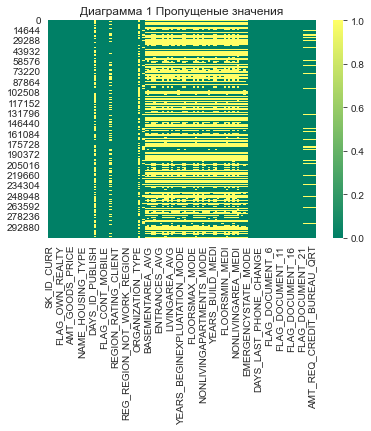

In [8]:
sns.heatmap(df_train.isnull(), cmap = 'summer').set(title='Диаграмма 1 Пропущеные значения')

In [9]:
miss_total = df_train.isnull().sum()

In [10]:
miss_per = 100 * miss_total/len(df_train)
miss_per.value_counts(ascending = False)

0.000000     55
13.501631     6
0.332021      4
49.760822     3
66.497784     3
55.179164     3
69.432963     3
50.193326     3
68.354953     3
59.376738     3
67.848630     3
53.295980     3
69.872297     3
50.348768     3
48.781019     3
50.749729     3
58.515956     3
68.386172     1
0.000325      1
65.990810     1
47.398304     1
50.840783     1
48.268517     1
50.176091     1
31.345545     1
0.000650      1
56.381073     1
0.214626      1
19.825307     1
0.420148      1
0.003902      1
0.090403      1
dtype: int64

По многим полям порядка 70% незаполненных значений - мы ничего не будем пока делать, чтобы не внести дополнительный вес фичей, которые в реальности не имеют отношения к определению целевой метрики, единственное - надо посмотреть, совпадают ли пропуски в тесте с train - **но как?**

Посмотрим есть ли дисбаланс классов в таргете

In [11]:
df_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

[Text(0.5, 1.0, 'Диаграмма 2 Распределение таргета')]

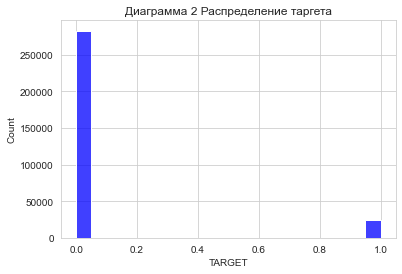

In [12]:
sns.histplot(df_train['TARGET'], color = "blue").set(title = 'Диаграмма 2 Распределение таргета')

Очевидный дисбаланс, порядка 92% приходится на 0 - без дефолта, возвращают кредит. Дисбаланс не всегда есть хорошо - **как задел для повышения качества модели**

## 2. Исследование признаков

Полей очень много, все исследовать не получиться, нужно определить какие фичи наиболее всего зависят от таргета, и уже их непосредственно исследовать

In [13]:
corr_features = df_train.corr()['TARGET'].sort_values()
corr_features

EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_EMPLOYED                 -0.044932
FLOORSMAX_AVG                 -0.044003
                                 ...   
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, Length: 106, dtype: float64

Корреляции нам показывает на признаки, которые стоит анализировать прежде всего:
Наибольшая положительная корреляция (возьмем первые 5):
- DAYS_BIRTH возраст
- REGION_RATING_CLIENT_W_CITY - рейтинг клиента в городе
- REGION_RATING_CLIENT - рейтинг клиента в регионе
- DAYS_LAST_PHONE_CHANGE - дата последнего смена телефона
- DAYS_ID_PUBLISH - публикация ID (?)
Наибольшая отрицательная корреляция (возьмем первые 3): непонятно пока что это такое
- EXT_SOURCE_3
- EXT_SOURCE_2
- EXT_SOURCE_1

### 2.1 Исследуем признаки с отрицательной корреляцией

Text(0.5, 1.0, 'Диаграмма Распределение признака EXT_SOURCE_3')

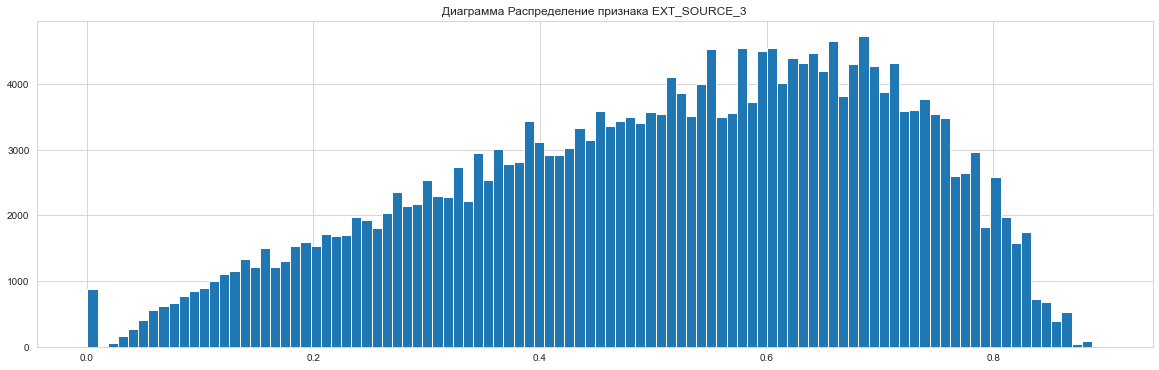

In [14]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_3'].hist(bins=100)
plt.title('Диаграмма Распределение признака EXT_SOURCE_3')

Text(0.5, 1.0, 'Диаграмма Распределения признака EXT_SOURCE_2')

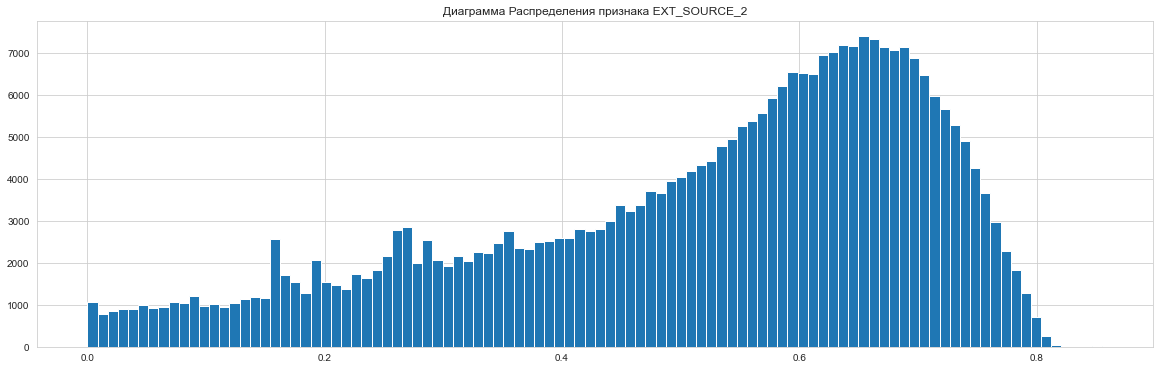

In [15]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_2'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

Text(0.5, 1.0, 'Диаграмма Распределения признака EXT_SOURCE_2')

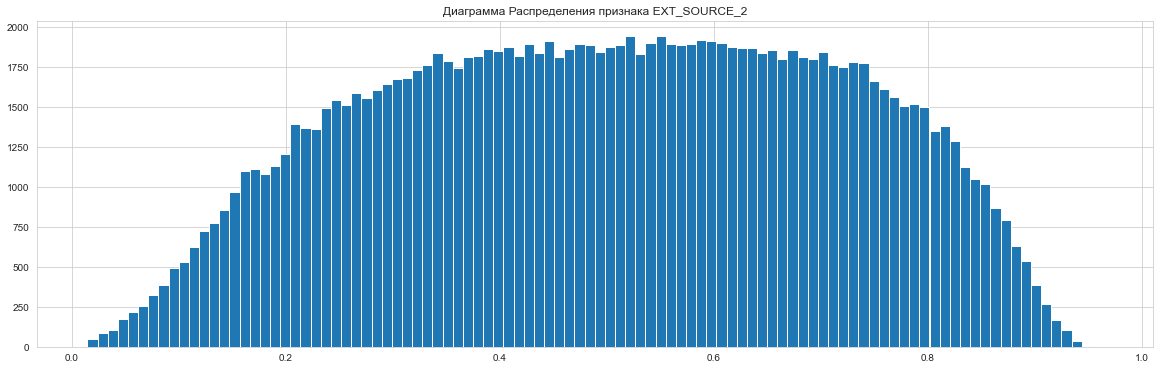

In [16]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_1'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

посмотрим в разрезе таргета

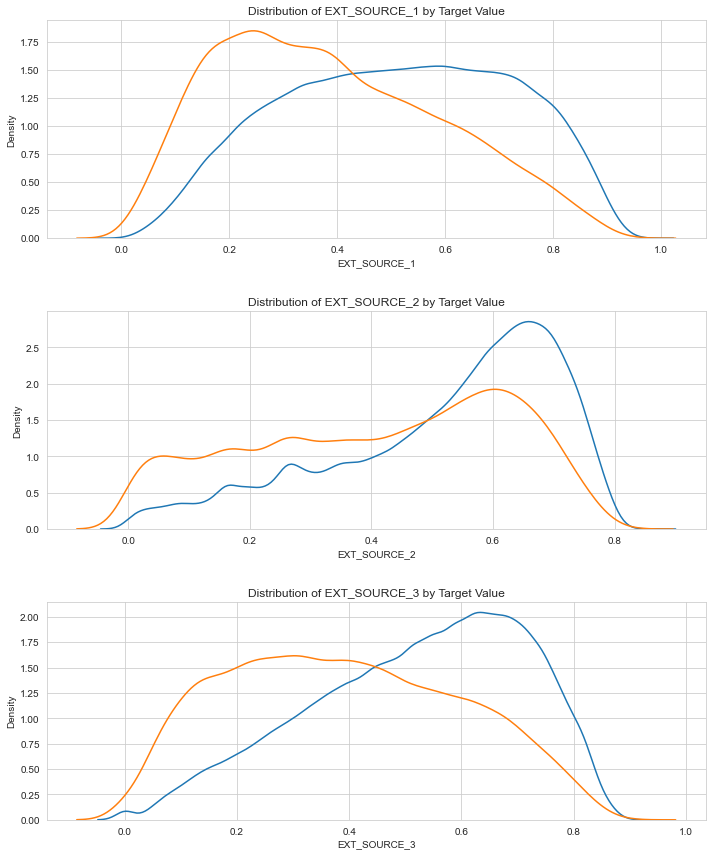

In [17]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # создаем график для каждой фичи
    plt.subplot(3, 1, i + 1)
    # займы которые вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0') # не вывел название таргета
    # займы которые не вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    # Названия графиков
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 3)

распределение абсолютно разное по классам, посмотрим на матрицу корреляции через heatmap

[Text(0.5, 1.0, 'матрица корреляции 1')]

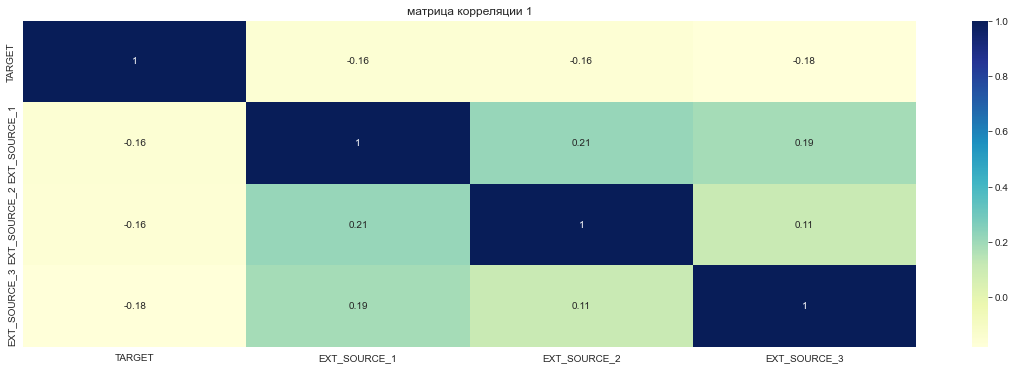

In [18]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(), cmap="YlGnBu", annot = True).set(title = 'матрица корреляции 1')

Ну вот видим, что этим признаки положительно коррелируют с собой, не критично конечно, но запомним это.
Посмотрим как все выбранные признаки (8 ед) коррелируют между собой.

[Text(0.5, 1.0, 'матрица корреляции 1')]

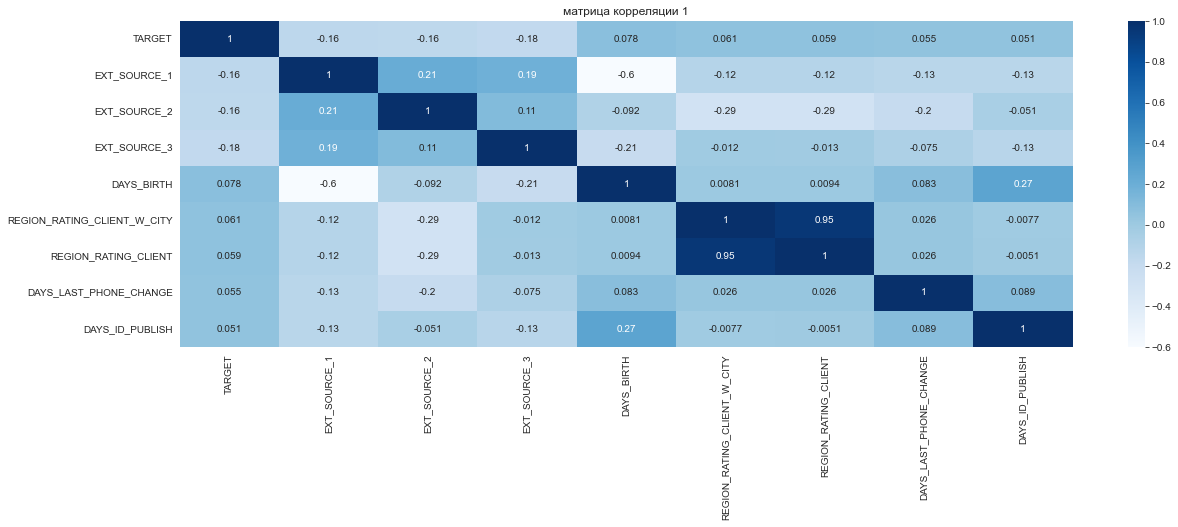

In [19]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']].corr(), cmap = "Blues", annot = True).set(title = 'матрица корреляции 1')

Так так,рейтинг региона очень сильно коррелирует с рейтингом клиента в городе, а DAYS_BIRTH имеют сильную обратную корреляцию с EXT_SOURCE_1, вот только что это такое EXT_SOURCE_1? в остальном все нормально вроде.

### 2.2 Исследуем признаки с положительной корреляцией

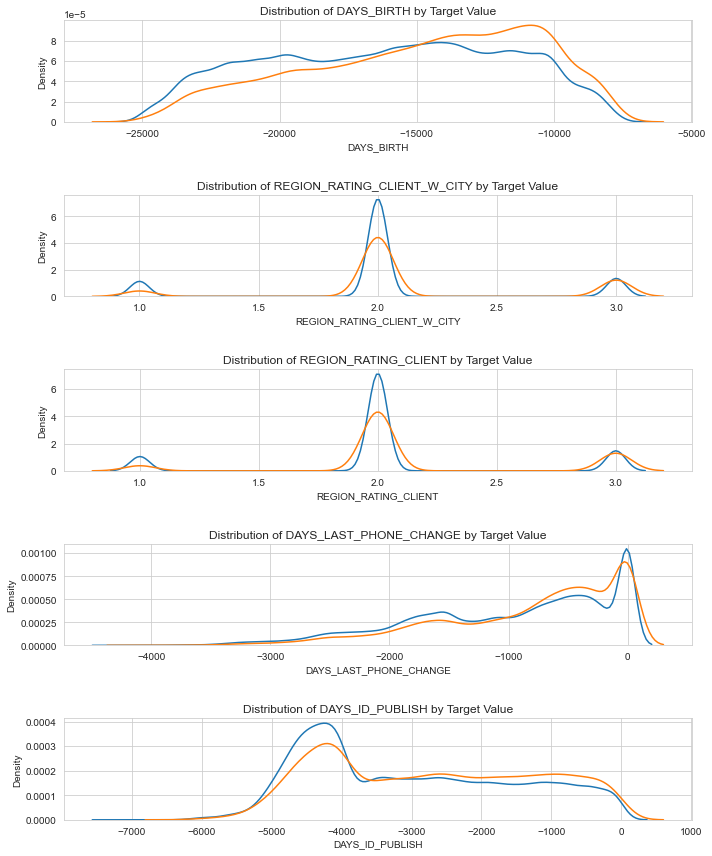

In [20]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']):

    # создаем график для каждой фичи
    plt.subplot(5, 1, i + 1)
    # займы которые вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0') # не вывел название таргета
    # займы которые не вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    # Названия графиков
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 3)

По данным графикам видно, что распределение фичи в зависимости от таргета более-менее равномерное

**Возраст**

In [21]:
df_train['DAYS_BIRTH'].head()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [22]:
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH']/365)

In [23]:
df_train['DAYS_BIRTH'].head()

0    25.920548
1    45.931507
2    52.180822
3    52.068493
4    54.608219
Name: DAYS_BIRTH, dtype: float64

In [24]:
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982698

Так понимаю это возраст заемщиков, перевели из отрицательных дней в года, перезаписали, корреляция сменила знак, но это не критично, потому как логика осталась - отрицательно коррелирует с невозвратом, т.е. чем выше возраст, тем ниже невозврат

**рейтинг клиента в городе**

In [25]:
df_train['REGION_RATING_CLIENT_W_CITY'].head()

0    2
1    1
2    2
3    2
4    2
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [26]:
df_train['REGION_RATING_CLIENT_W_CITY'].value_counts(normalize=True)

2    0.746263
3    0.142629
1    0.111108
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

**рейтинг клиента в регионе**
тут такая же картина, неудивительно почему они коррелируют

In [27]:
df_train['REGION_RATING_CLIENT'].value_counts(normalize=True)

2    0.738133
3    0.157165
1    0.104702
Name: REGION_RATING_CLIENT, dtype: float64

**дата последнего смена телефона**

In [28]:
df_train['DAYS_LAST_PHONE_CHANGE'].head()

0   -1134.0
1    -828.0
2    -815.0
3    -617.0
4   -1106.0
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [29]:
df_train['DAYS_LAST_PHONE_CHANGE'] = abs(df_train['DAYS_LAST_PHONE_CHANGE']/365)
df_train['DAYS_LAST_PHONE_CHANGE'].head()

0    3.106849
1    2.268493
2    2.232877
3    1.690411
4    3.030137
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [30]:
df_train['DAYS_LAST_PHONE_CHANGE'].sort_values(ascending=False)

191568    11.758904
137198    11.465753
294270    11.432877
101177    11.378082
106063    11.317808
            ...    
235186     0.000000
68881      0.000000
235190     0.000000
153756     0.000000
15709           NaN
Name: DAYS_LAST_PHONE_CHANGE, Length: 307511, dtype: float64

**DAYS_ID_PUBLISH**

In [31]:
df_train['DAYS_ID_PUBLISH'].head()

0   -2120
1    -291
2   -2531
3   -2437
4   -3458
Name: DAYS_ID_PUBLISH, dtype: int64

In [32]:
df_train['DAYS_ID_PUBLISH'] = abs(df_train['DAYS_ID_PUBLISH']/365)
df_train['DAYS_ID_PUBLISH'].head()

0    5.808219
1    0.797260
2    6.934247
3    6.676712
4    9.473973
Name: DAYS_ID_PUBLISH, dtype: float64

не особо заметны выбросы, но график явно не традиционной ориентации

## 3. Отправляем в модель

In [33]:
# уберем таргет из тренировочной выборки, категориальные фичи он должен съесть
target = df_train['TARGET']
train = df_train.drop(labels= ['TARGET'], axis = 1)

In [34]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
test = df_test
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
train, test = train.align(train, join = 'inner', axis = 1)

print('Тренировочная выборка', train.shape)
print('Тестовая выборка', test.shape)

Тренировочная выборка (307511, 121)
Тестовая выборка (307511, 121)


In [37]:
cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [38]:
for c in cat:
    train[c] = train[c].astype('category')

In [39]:
model = LGBMClassifier(objective="binary")
model.fit(train, target, categorical_feature=cat)

C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(objective='binary')

In [40]:
for c in cat:
    test[c] = test[c].astype('category')

In [41]:
predict = model.predict_proba(test)[:, 1]

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score
metrics = roc_auc_score(target, predict)
print('LightGBM: ROC AUC=%.3f' % (metrics))


LightGBM: ROC AUC=0.799


In [43]:
print(train.dtypes)

SK_ID_CURR                       int64
NAME_CONTRACT_TYPE            category
CODE_GENDER                   category
FLAG_OWN_CAR                  category
FLAG_OWN_REALTY               category
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY      float64
AMT_REQ_CREDIT_BUREAU_WEEK     float64
AMT_REQ_CREDIT_BUREAU_MON      float64
AMT_REQ_CREDIT_BUREAU_QRT      float64
AMT_REQ_CREDIT_BUREAU_YEAR     float64
Length: 121, dtype: object


In [44]:
train_2 = train.copy()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


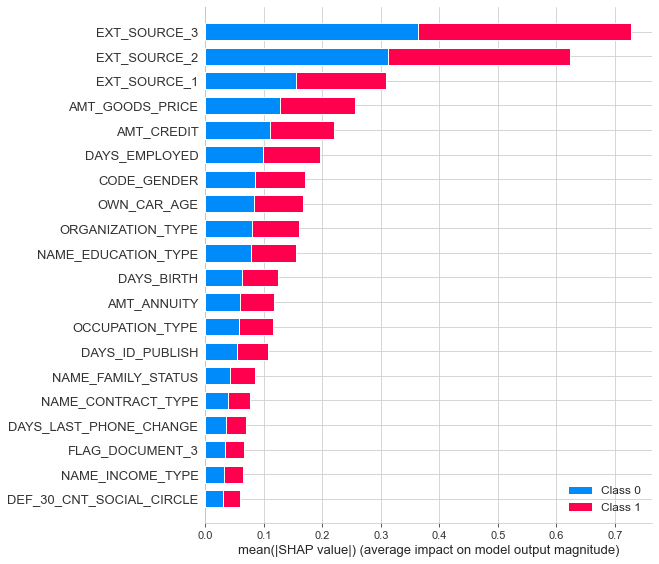

In [45]:

#explainer = shap.Explainer(model)
#shap_values = explainer(train)

#shap.plots.beeswarm(shap_values)
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values, train)

Модель определила признаки, которые дают сильный вклад в предсказание, которые мы не стали анализировать, например AMT_GOOD_Price,

Добавляем бюро

In [46]:
bureau = pd.read_csv('bureau.csv')
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


[Text(0.5, 1.0, 'Диаграмма Пропущеные значения')]

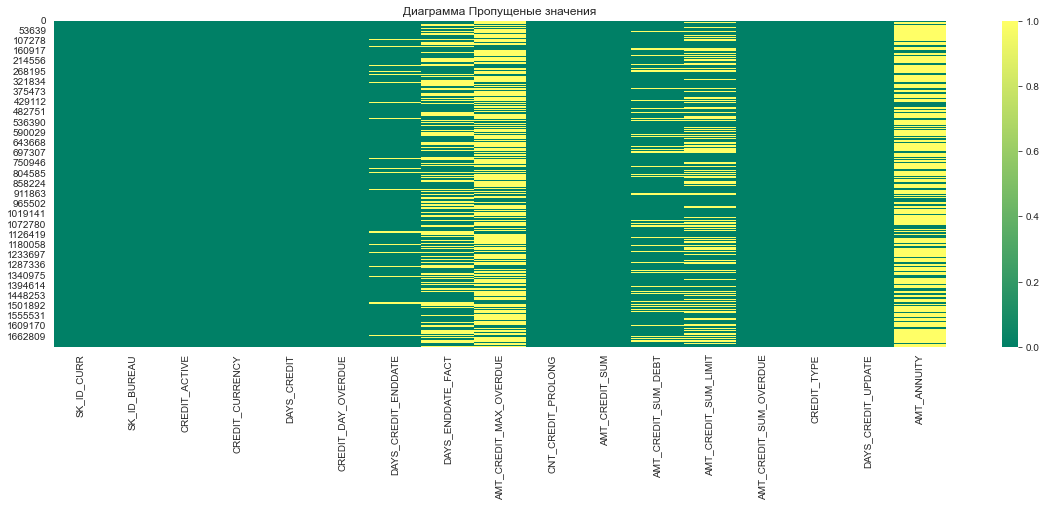

In [47]:
sns.heatmap(bureau.isnull(), cmap = 'summer').set(title='Диаграмма Пропущеные значения')

In [48]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


попробуем привести к нужному типу данных

In [49]:
print(bureau.dtypes)

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object


In [50]:
cat_b = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
for c in cat_b:
    bureau[c] = bureau[c].astype('category')
print(bureau.dtypes)

SK_ID_CURR                   int64
SK_ID_BUREAU                 int64
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT                  int64
CREDIT_DAY_OVERDUE           int64
DAYS_CREDIT_ENDDATE        float64
DAYS_ENDDATE_FACT          float64
AMT_CREDIT_MAX_OVERDUE     float64
CNT_CREDIT_PROLONG           int64
AMT_CREDIT_SUM             float64
AMT_CREDIT_SUM_DEBT        float64
AMT_CREDIT_SUM_LIMIT       float64
AMT_CREDIT_SUM_OVERDUE     float64
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE           int64
AMT_ANNUITY                float64
dtype: object


In [51]:
df_gr = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['max','mean','min'])
df_gr.head()

,max,mean,min
SK_ID_CURR,,,
100001,378000.0,207623.571429,85500.0
100002,450000.0,108131.945625,0.0
100003,810000.0,254350.125000,22248.0
100004,94537.8,94518.900000,94500.0
100005,568800.0,219042.000000,29826.0


In [52]:
train_1 = train.merge(right=df_gr.reset_index(), how='left', on='SK_ID_CURR')
test_1 = test.merge(right=df_gr.reset_index(), how='left', on='SK_ID_CURR')

In [53]:
train_1, test_1 = train_1.align(train_1, join='inner', axis=1)

In [54]:
model_1 = LGBMClassifier(objective="binary")
model_1.fit(train_1, target, categorical_feature=cat)

Using categorical_feature in Dataset.


LGBMClassifier(objective='binary')

In [55]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 124 entries, SK_ID_CURR to min
dtypes: category(16), float64(70), int64(38)
memory usage: 260.4 MB


In [56]:
predict_1 = model_1.predict_proba(test_1)[:,1]

In [57]:
predict_1

array([0.45920144, 0.03406884, 0.03386352, ..., 0.04524482, 0.10050257,
       0.07218574])

In [58]:
metrics_1 = roc_auc_score(target, predict_1)

In [59]:
print('LightGBM: ROC AUC=%.3f' % (metrics_1))

LightGBM: ROC AUC=0.802


Добавляем другие таблицы и делаем все

In [60]:
bur_balance = pd.read_csv(r'C:\Users\user\Desktop\HCB\bureau_balance.csv')
credit_card = pd.read_csv(r'C:\Users\user\Desktop\HCB\credit_card_balance.csv')
instal_pay = pd.read_csv(r'C:\Users\user\Desktop\HCB\installments_payments.csv')
Posh_card = pd.read_csv(r'C:\Users\user\Desktop\HCB\POS_CASH_balance.csv')

### Задача повысить скор на основе генеранции новых фич
ДАНО:
* дефолтный сет скор составляет AUC 0,799
* сет с бюро составляет AUC 0,802
Посмострим дополнительно какие фичи можно нагенерить в обоих случаях для увеличения предсказательной силы

In [107]:
dt_new = df_train.copy()
dt_new.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Посмотрим описание колонок в целом, нас интересует численные столбцы

In [62]:
description = pd.read_csv(r'C:\Users\user\Desktop\HCB\HomeCredit_columns_description.csv', encoding="ISO-8859-1")
description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


В базовом датасете:
AMT_INCOME_TOTAL - общий доход
AMT_CREDIT - сумма кредита
AMT_ANNUITY - сумма платежа по кредиту
AMT_GOODS_PRICE - цена товара, на который одобрили кредит

По остальным колонкам много пропусков, весьма ненадежно из них получать новые данные

Попробуем синтезировать числовые фичи и добавить их в основной датасет. Одной из важных характеристик является кредитная ставка, поскольку она закладывается с учетом риск. Ее нет в дата сете и ее не вывести, можно принять условно, что соотношение платежа по кредиту к общей кредитной сумме условно может отражать ставку риска. Также на дефолт может влиять соотношение общего дохода и суммы кредита. Платеж по кредиту, если он автоматический, зачастую зависит от уровня доходов, но ставка для высокорискованных заемщиков как правило выше. Общий стаж работы тоже влияет (допустим банк одобряет клиентам старше 22, но у каждого может быть свой трудовой стаж).

Бездумно генерить кучу соотношений мне представляется нецелесообразным, новые фичи должны быть как минимум интерпретированы для заказчика, например общий доход/количество отработанных дней - это не стоимость трудо-дня за всю историю, а просто текущий доход на общий стаж - т.е. кривая метрика


Посмотрим пропуска в колонках

In [108]:
dt_new['AMT_INCOME_TOTAL'].isnull().sum()

0

In [109]:
dt_new['AMT_CREDIT'].isnull().sum()

0

In [110]:
dt_new['AMT_ANNUITY'].isnull().sum()

12

In [111]:
dt_new['AMT_GOODS_PRICE'].isnull().sum()

278

In [112]:
diff = dt_new['AMT_CREDIT'] - dt_new['AMT_GOODS_PRICE']
diff

0          55597.5
1         164002.5
2              0.0
3          15682.5
4              0.0
            ...   
307506     29700.0
307507     44550.0
307508     92664.0
307509     50607.0
307510         0.0
Length: 307511, dtype: float64

Фича цена - является фактически эквивалентом выданного кредита, так как там много пропусков - делать с ней ничего не будем, если посчитать разницу там, где пропуски будут значения - внесет просто шум в данные. Строки по аннуитету, где есть пропуски всего 12 - это не критично.

## генерим новые фичи

1. Условная процентная ставка (платеж по кредиту/сумму кредита)

In [114]:
dt_new['CREDIT_PERCENT'] = dt_new['AMT_ANNUITY'] / dt_new['AMT_CREDIT']

2. Соотношение платеж к ЗП

In [115]:
dt_new['ANNUITY_INCOME'] = dt_new['AMT_ANNUITY'] / dt_new['AMT_INCOME_TOTAL']

3. Соотношение величины кредита к ЗП

In [116]:
dt_new['CREDIT_INCOME'] = dt_new['AMT_CREDIT'] / dt_new['AMT_INCOME_TOTAL']

4. Количество трудового стажа

In [117]:
dt_new['BIRTH_EMPLOYED'] = dt_new['DAYS_EMPLOYED'] / dt_new['DAYS_BIRTH']

In [91]:
dt_new['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

5. Количество ртов в семье тоже может быть важной фичей

In [118]:
dt_new['CHILDREN_CNT_INCOME_PERCENT'] = dt_new['AMT_INCOME_TOTAL']/dt_new['CNT_CHILDREN']

6. На дефолте самая высокий вклад внесли фичи внешние EXT - просто усредним и посмотрим какой вклад внесет среднее значение

In [119]:
dt_new['NEW_EXT_SOURCES_MEAN'] = dt_new[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

Думаю, что 6 новых фичей хотя не ухудшат модель, добавим эти фичи в тест

In [121]:
test_3 = df_test.copy()
test_3['CREDIT_PERCENT'] = test_3['AMT_ANNUITY'] / test_3['AMT_CREDIT']
test_3['ANNUITY_INCOME'] = test_3['AMT_ANNUITY'] / test_3['AMT_INCOME_TOTAL']
test_3['CREDIT_INCOME'] = test_3['AMT_CREDIT'] / test_3['AMT_INCOME_TOTAL']
test_3['BIRTH_EMPLOYED'] = test_3['DAYS_EMPLOYED'] / test_3['DAYS_BIRTH']
test_3['CHILDREN_CNT_INCOME_PERCENT'] = test_3['AMT_INCOME_TOTAL'] / test_3['CNT_CHILDREN']
test_3['NEW_EXT_SOURCES_MEAN'] = test_3[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

In [122]:
target_3 = dt_new['TARGET']
train_3 = dt_new.drop(labels=['TARGET'], axis=1)
train_3.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_PERCENT,ANNUITY_INCOME,CREDIT_INCOME,BIRTH_EMPLOYED,CHILDREN_CNT_INCOME_PERCENT,NEW_EXT_SOURCES_MEAN
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,1.0,0.060749,0.121978,2.007889,-24.575098,inf,0.161787
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.027598,0.132217,4.790750,-25.864599,inf,0.466757
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.050000,0.100000,2.000000,-4.311929,inf,0.642739
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,0.094941,0.219900,2.316167,-58.365430,inf,0.650442
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.042623,0.179963,4.222222,-55.632651,inf,0.322738


In [123]:
test_3.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_PERCENT,ANNUITY_INCOME,CREDIT_INCOME,BIRTH_EMPLOYED,CHILDREN_CNT_INCOME_PERCENT,NEW_EXT_SOURCES_MEAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.036147,0.152300,4.213333,0.121044,inf,0.567263
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,3.0,0.077973,0.175455,2.250182,0.247398,inf,0.429869
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,1.0,4.0,0.105202,0.344578,3.275378,0.222477,inf,0.655389
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,3.0,0.031123,0.155614,5.000000,0.133515,157500.0,0.549372
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,0.051266,0.178150,3.475000,0.168021,180000.0,0.313916


In [131]:
train_n, test_n = train_3.align(train_3, join='inner', axis=1)

cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_n[c] = train_n[c].astype('category')
model_3 = LGBMClassifier(objective="binary")
model_3.fit(train_n, target, categorical_feature=cat)
for c in cat:
    test_n[c] = test_n[c].astype('category')
predict_3 = model_3.predict_proba(test_n)[:, 1]
print('Тренировочная выборка', train_n.shape)
print('Тестовая выборка', test_n.shape)

Using categorical_feature in Dataset.


Тренировочная выборка (307511, 127)
Тестовая выборка (307511, 127)


In [134]:
metrics_3 = roc_auc_score(target_3, predict_3)
print('LightGBM: ROC AUC=%.3f' % (metrics_3))

LightGBM: ROC AUC=0.806


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


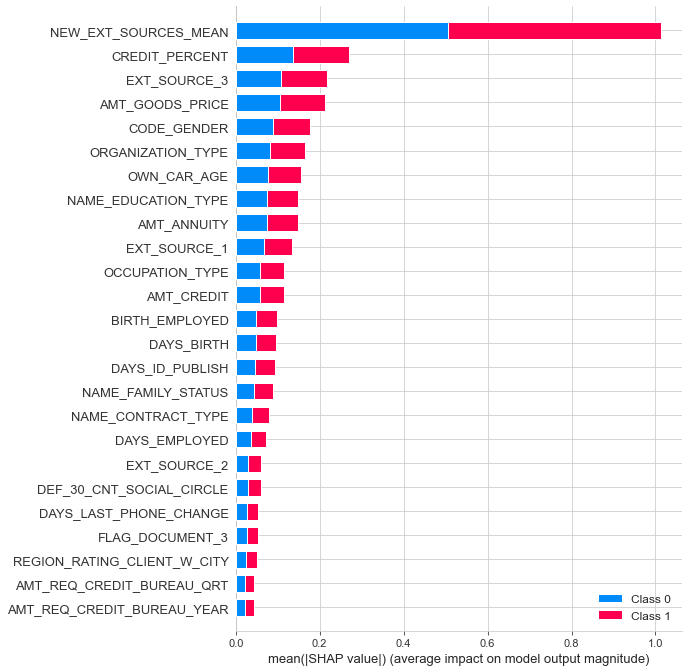

In [139]:
shap_test = shap.TreeExplainer(model_3).shap_values(train_n)
shap.summary_plot(shap_test, test_n,
                  max_display=25, auto_size_plot=True)

Гуд - метрика выросла с 0,799 до 0,806. Добавим бюро дефолтное и с фичами, правда теперь у нас появилась суперфича - среднее значение EXT_sourse

In [140]:
bureau_3 = pd.read_csv('bureau.csv')
cat_b = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
for c in cat_b:
    bureau_3[c] = bureau_3[c].astype('category')
print(bureau_3.dtypes)

SK_ID_CURR                   int64
SK_ID_BUREAU                 int64
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT                  int64
CREDIT_DAY_OVERDUE           int64
DAYS_CREDIT_ENDDATE        float64
DAYS_ENDDATE_FACT          float64
AMT_CREDIT_MAX_OVERDUE     float64
CNT_CREDIT_PROLONG           int64
AMT_CREDIT_SUM             float64
AMT_CREDIT_SUM_DEBT        float64
AMT_CREDIT_SUM_LIMIT       float64
AMT_CREDIT_SUM_OVERDUE     float64
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE           int64
AMT_ANNUITY                float64
dtype: object


In [143]:
df_gr_3 = bureau_3.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['max','mean','min'])
df_gr_3.head()

,max,mean,min
SK_ID_CURR,,,
100001,378000.0,207623.571429,85500.0
100002,450000.0,108131.945625,0.0
100003,810000.0,254350.125000,22248.0
100004,94537.8,94518.900000,94500.0
100005,568800.0,219042.000000,29826.0


In [156]:
train_4 = train_3.merge(right=df_gr_3.reset_index(), how='left', on='SK_ID_CURR')
test_4 = test_3.merge(right=df_gr_3.reset_index(), how='left', on='SK_ID_CURR')
train_nb, test_nb = train_4.align(train_4, join='inner', axis=1)

cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_nb[c] = train_nb[c].astype('category')

for c in cat:
    test_nb[c] = test_nb[c].astype('category')

model_4 = LGBMClassifier(objective="binary")
model_4.fit(train_nb, target_3, categorical_feature=cat)
predict_4 = model_4.predict_proba(test_nb)[:, 1]
metrics_4 = roc_auc_score(target_3, predict_4)
print('LightGBM: ROC AUC=%.3f' % (metrics_4))

Using categorical_feature in Dataset.


LightGBM: ROC AUC=0.805


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


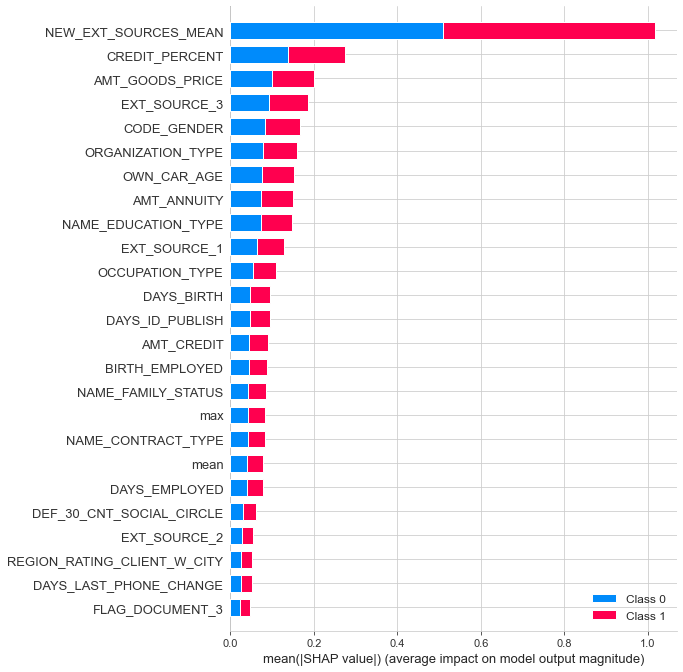

In [146]:
shap_test_2 = shap.TreeExplainer(model_4).shap_values(train_nb)
shap.summary_plot(shap_test_2, test_nb,
                  max_display=25, auto_size_plot=True)

Метрика стала хуже, но незначительно, все также практически сильное влияние одной фичи, попробуем переделать бюро и не брать в расчет метрку макс/мин/сред

1. Длительность кредита
2. Количество дней между подачей заявок на кредит
3. Ставка по кредиту согласно бюро
4. Просрочка в общей задолжености
5. Текущий кредит в общей задолжности
6. Доля кредитного лимита по карте к общей задолжности
7. Средний размер пролонгации кредита

Желательно строить только те столбцы, по которым пропуском мало - см. график в строке 47

In [147]:
bureau_4 = bureau_3.copy()
bureau_4.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [165]:

#1
bureau_4['CREDIT_DURATION'] = -bureau_4['DAYS_CREDIT'] + bureau_4['DAYS_CREDIT_ENDDATE']
#2
bureau_4['ENDDATE_DIFF'] = bureau_4['DAYS_CREDIT_ENDDATE'] - bureau_4['DAYS_ENDDATE_FACT']
#3
bureau_4['DEBT_rate'] = bureau_4['AMT_ANNUITY'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#4
bureau_4['DEBT_over'] = bureau_4['AMT_CREDIT_SUM_OVERDUE'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#5
bureau_4['current_rate_debt'] = bureau_4['AMT_CREDIT_SUM'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#6
bureau_4['DEBT_PERCENTAGE'] = bureau_4['AMT_CREDIT_SUM_LIMIT'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#7
bureau_4['CNT_sum_CREDIT_PROLONG'] = bureau_4['AMT_CREDIT_SUM_DEBT'] / bureau_4['CNT_CREDIT_PROLONG']

bureau_4

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIFF,DEBT_rate,DEBT_over,current_rate_debt,DEBT_PERCENTAGE,CNT_sum_CREDIT_PROLONG
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,Consumer credit,-131,NaN,344.0,0.0,NaN,NaN,inf,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,Credit card,-20,NaN,1283.0,NaN,NaN,0.0,1.313163,NaN,inf
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,Consumer credit,-16,NaN,731.0,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,Consumer credit,-21,NaN,1826.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,...,Microloan,-19,NaN,14.0,NaN,NaN,0.0,1.000000,0.0,inf
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,...,Consumer credit,-2493,NaN,215.0,60.0,NaN,NaN,inf,NaN,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,...,Consumer credit,-967,NaN,181.0,-658.0,NaN,NaN,NaN,NaN,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,...,Consumer credit,-1508,NaN,365.0,0.0,NaN,NaN,inf,NaN,NaN


In [173]:
df_gr_4 = bureau_4.groupby('SK_ID_CURR')
df_gr_4.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIFF,DEBT_rate,DEBT_over,current_rate_debt,DEBT_PERCENTAGE,CNT_sum_CREDIT_PROLONG
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,Consumer credit,-131,NaN,344.0,0.0,NaN,NaN,inf,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,Credit card,-20,NaN,1283.0,NaN,NaN,0.0,1.313163,NaN,inf
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,Consumer credit,-16,NaN,731.0,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.50,0,...,Consumer credit,-21,NaN,1826.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716399,232638,5057553,Active,currency 1,-613,0,721.0,NaN,NaN,0,...,Credit card,-42,NaN,1334.0,NaN,NaN,0.0,1.096697,0.0,inf
1716401,145715,5057569,Closed,currency 1,-2333,0,-2027.0,-1984.0,173.07,0,...,Consumer credit,-1984,NaN,306.0,-43.0,NaN,NaN,inf,NaN,NaN
1716410,280228,5057642,Active,currency 1,-575,0,813.0,NaN,NaN,0,...,Credit card,-46,NaN,1388.0,NaN,NaN,NaN,inf,NaN,NaN
1716411,232118,5057652,Closed,currency 1,-821,0,-425.0,-545.0,0.00,0,...,Consumer credit,-545,NaN,396.0,120.0,NaN,NaN,inf,NaN,NaN


In [176]:
train_5 = train_3.merge(right=df_gr_4.reset_index(), how='left', on='SK_ID_CURR')
test_5 = test_3.merge(right=df_gr_4.reset_index(), how='left', on='SK_ID_CURR')
train_b, test_b = train_5.align(train_5, join='inner', axis=1)


AttributeError: 'DataFrameGroupBy' object has no attribute 'reset_index'

In [ ]:
cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_b[c] = train_b[c].astype('category')

for c in cat:
    test_b[c] = test_b[c].astype('category')

model_5 = LGBMClassifier(objective="binary")
model_5.fit(train_b, target_3, categorical_feature=cat)
predict_5 = model_5.predict_proba(test_b)[:, 1]
metrics_5 = roc_auc_score(target_3, predict_5)
print('LightGBM: ROC AUC=%.3f' % (metrics_5))